In [1]:
import geopandas as gpd
import pandas as pd
import ee
import numpy as np
from scipy.stats import linregress, gaussian_kde
from src.data import mtbs
from src.data import raster
from src.data import pd_utils
from src.data import gedi_pipeline
from src.visualization.dists import plot_pdf
from src.visualization.gedi_viz import geo_plot
import rasterio as rio
import matplotlib.pyplot as plt
from shapely.geometry import Point
from rasterio.plot import show
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
from src.data import k_nn

sns.set_theme()

import importlib
importlib.reload(raster)
importlib.reload(gedi_pipeline)
importlib.reload(k_nn)

2023-05-24 19:22:28,944 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.k_nn' from '/home/jk871/fire-regen/src/data/k_nn.py'>

In [2]:
gedi_burned_trees, gedi_unburned_trees = gedi_pipeline.process_gedi_shots_for_regrowth_analysis('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv', True)

2023-05-24 19:23:27,353 DEBUG: Total number of GEDI shots available for the region:         9884257 [in process_gedi_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:101]
2023-05-24 19:23:58,076 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:36]
2023-05-24 19:23:58,388 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:41]
2023-05-24 19:23:59,682 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in filter_shots at /home/jk871/fire-regen/src/data/gedi_pipeline.py:47]
2023-05-24 19:24:00,100 DEBUG: Number of shots that happened after fires:                    1248004 [in filter_shots_for_regrowth_analysis at /home/jk871/fire-regen/src/data/gedi_pipeline.py:64]
2023-05-24 19:24:00,307 DEBUG: Number of shots that burned exactly once:      

In [4]:
df = pd.concat([gedi_burned_trees, gedi_unburned_trees])

In [56]:
df = gedi_burned_trees

In [5]:
df.columns

Index(['shot_number', 'absolute_time', 'lon_lowestmode', 'lat_lowestmode',
       'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se', 'l2_quality_flag',
       'l4_quality_flag', 'degrade_flag', 'beam_type', 'sensitivity',
       'pft_class', 'geometry', 'burn_severity_3x3', 'burn_severity_mean',
       'burn_severity_std', 'burn_severity_median', 'burn_year_3x3',
       'burn_year_mean', 'burn_year_std', 'burn_year_median',
       'burn_counts_3x3', 'burn_counts_mean', 'burn_counts_std',
       'burn_counts_median', 'land_cover_2x2', 'land_cover_mean',
       'land_cover_std', 'land_cover_median', 'gedi_year', 'gedi_month',
       'time_since_burn', 'time_since_burn_cat'],
      dtype='object')

In [9]:
#cats=["Sex","Embarked"]
conts=['agbd', 'time_since_burn', 'lon_lowestmode', 'lat_lowestmode', 'gedi_year']
dep="burn_severity_mean"

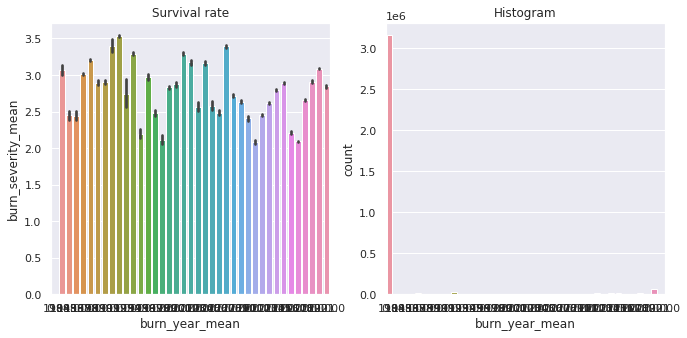

In [8]:
fig,axs = plt.subplots(1,2, figsize=(11,5))
sns.barplot(data=df, y=dep, x="burn_year_mean", ax=axs[0]).set(title="Survival rate")
sns.countplot(data=df, x="burn_year_mean", ax=axs[1]).set(title="Histogram");

In [57]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(df, test_size=0.25)

In [58]:
def xs_y(df):
    xs = df[conts].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

In [59]:
preds = val_xs.time_since_burn>-1

In [60]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(val_y, preds)

1.948634131368938

(0.0, 700.0)

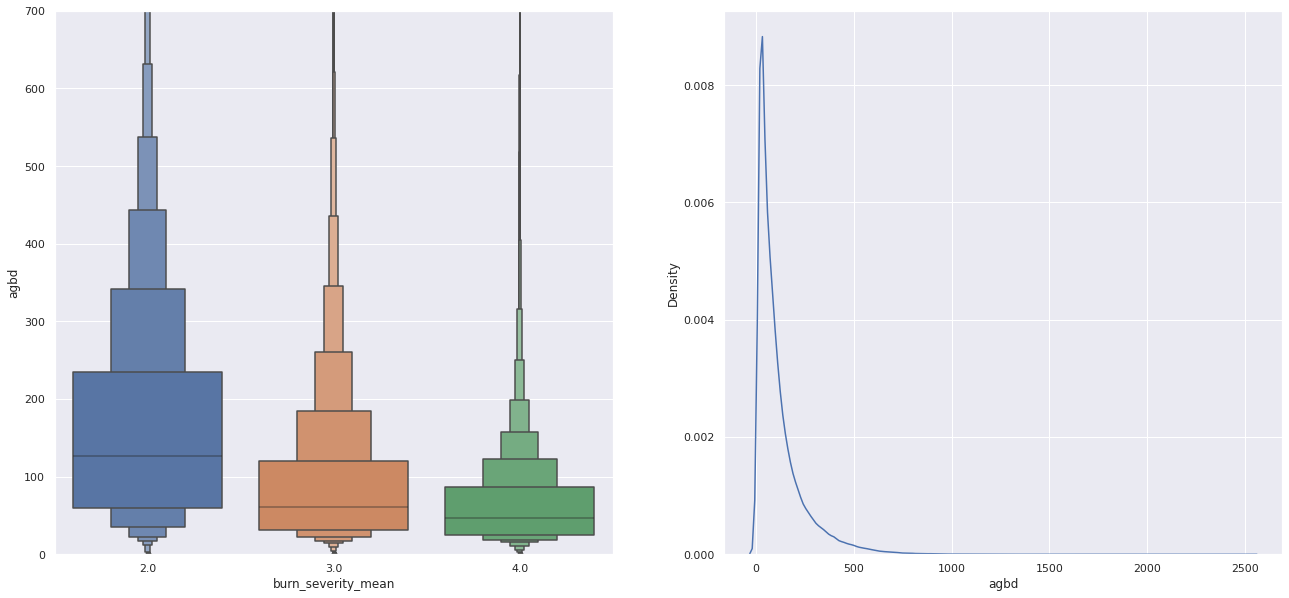

In [61]:
df_fare = trn_df[trn_df.agbd>0]
fig,axs = plt.subplots(1,2, figsize=(22,10))
sns.boxenplot(data=df_fare, x=dep, y="agbd", ax=axs[0])
sns.kdeplot(data=df_fare, x="agbd", ax=axs[1])
axs[0].set_ylim((0, 700))

In [62]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

In [63]:
    
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

In [64]:
score(trn_xs["time_since_burn"], trn_y, -1)

0.8822052205781528

In [65]:
score(trn_xs["agbd"], trn_y, 150)

0.8156651925242911

In [66]:
trn_xs.lon_lowestmode.mean()

-120.49387599102938

In [68]:
def iscore(nm, split):
    col = trn_xs[nm]
    return score(col, trn_y, split)

from ipywidgets import interact
interact(nm=conts, split=90)(iscore)

interactive(children=(Dropdown(description='nm', options=('agbd', 'time_since_burn', 'lon_lowestmode', 'lat_lo…

<function __main__.iscore(nm, split)>

In [69]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [70]:
m = DecisionTreeClassifier(max_leaf_nodes=4).fit(trn_xs, trn_y)

In [80]:
m = DecisionTreeClassifier(min_samples_leaf=5000).fit(trn_xs, trn_y)

In [81]:
import graphviz
import regex as re

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    gviz_input = re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s)
    print(gviz_input)
    print(type(gviz_input))
    #return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

In [82]:
draw_tree(m, trn_xs, size=10)

digraph Tree { size=10; ratio=0.6
node [shape=box, style="filled, rounded", color="black", fontname="helvetica"] ;
edge [fontname="helvetica"] ;
0 [label=<agbd &le; 136.97<br/>gini = 0.65<br/>samples = 195480<br/>value = [81588, 42780, 71112]>, fillcolor="#fdf4ee"] ;
1 [label=<lat_lowestmode &le; 38.34<br/>gini = 0.64<br/>samples = 141820<br/>value = [43391, 33959, 64470]>, fillcolor="#e4d5f9"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label=<agbd &le; 40.43<br/>gini = 0.66<br/>samples = 49767<br/>value = [18959, 15187, 15621]>, fillcolor="#fcf3ec"] ;
1 -> 2 ;
3 [label=<lat_lowestmode &le; 36.79<br/>gini = 0.65<br/>samples = 19561<br/>value = [4910, 6399, 8252]>, fillcolor="#ede3fb"] ;
2 -> 3 ;
4 [label=<gini = 0.62<br/>samples = 5436<br/>value = [1442, 1192, 2802]>, fillcolor="#d4bcf6"] ;
3 -> 4 ;
5 [label=<lat_lowestmode &le; 37.69<br/>gini = 0.65<br/>samples = 14125<br/>value = [3468, 5207, 5450]>, fillcolor="#fcfafe"] ;
3 -> 5 ;
6 [label=<gini = 0.66<br/>sa